Cell 1: Imports & Configuration

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, accuracy_score, classification_report, confusion_matrix

# Visualization Settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

Cell 2: Load & Merge Data

In [3]:
# --- FILE FINDER ---
def find_file(filename, folder="data"):
    # 1. Check directly for 'data/filename' (If you are in the Root folder)
    path1 = os.path.join(folder, filename)

    # 2. Check one level up '../data/filename' (If you are in a Subfolder like 'notebooks')
    path2 = os.path.join("..", folder, filename)

    # 3. Check directly in the current folder (If files are side-by-side)
    path3 = filename

    if os.path.exists(path1):
        return path1
    elif os.path.exists(path2):
        return path2
    elif os.path.exists(path3):
        return path3
    else:
        return None

# --- LOAD DATA ---
master_path = find_file("Turkey_Weather_Master.csv")
locs_path = find_file("locations.csv")

if master_path and locs_path:
    print(f"Files found:\n -> {master_path}\n -> {locs_path}")

    df = pd.read_csv(master_path)
    locs = pd.read_csv(locs_path)

    # Merge Coordinates
    # Match 'plate_code' from weather data with 'plaka' from location data
    df = df.merge(locs[['plaka', 'lat', 'lon']], left_on='plate_code', right_on='plaka', how='left')

    # Convert Date column to Datetime objects
    df['date'] = pd.to_datetime(df['date'])

    print(f"Dataset Shape: {df.shape}")
    print(df.head())

else:
    print("ERROR: Files not found!")
    print(f"Current Working Directory: {os.getcwd()}")
    print("Please ensure 'Turkey_Weather_Master.csv' and 'locations.csv' are inside the 'data' folder.")

Files found:
 -> ..\data\Turkey_Weather_Master.csv
 -> ..\data\locations.csv
Dataset Shape: (680562, 12)
                       date   city  plate_code   max_temp  min_temp  \
0 2002-12-31 21:00:00+00:00  ADANA           1  10.234500    7.2845   
1 2003-01-01 21:00:00+00:00  ADANA           1  10.934501    8.0845   
2 2003-01-02 21:00:00+00:00  ADANA           1  12.284500    7.8845   
3 2003-01-03 21:00:00+00:00  ADANA           1  11.384500    7.8845   
4 2003-01-04 21:00:00+00:00  ADANA           1  13.334500    7.6345   

   precipitation  wind_speed  weather_code       weather_desc  plaka   lat  \
0       8.000001   12.287555          61.0       Rain: Slight      1  37.0   
1      16.600000   14.512064          61.0       Rain: Slight      1  37.0   
2       1.200000   13.849477          53.0  Drizzle: Moderate      1  37.0   
3       9.200001   14.904173          61.0       Rain: Slight      1  37.0   
4       0.200000   11.525623          51.0     Drizzle: Light      1  37.0   


Cell 3: Exploratory Data Analysis (EDA)

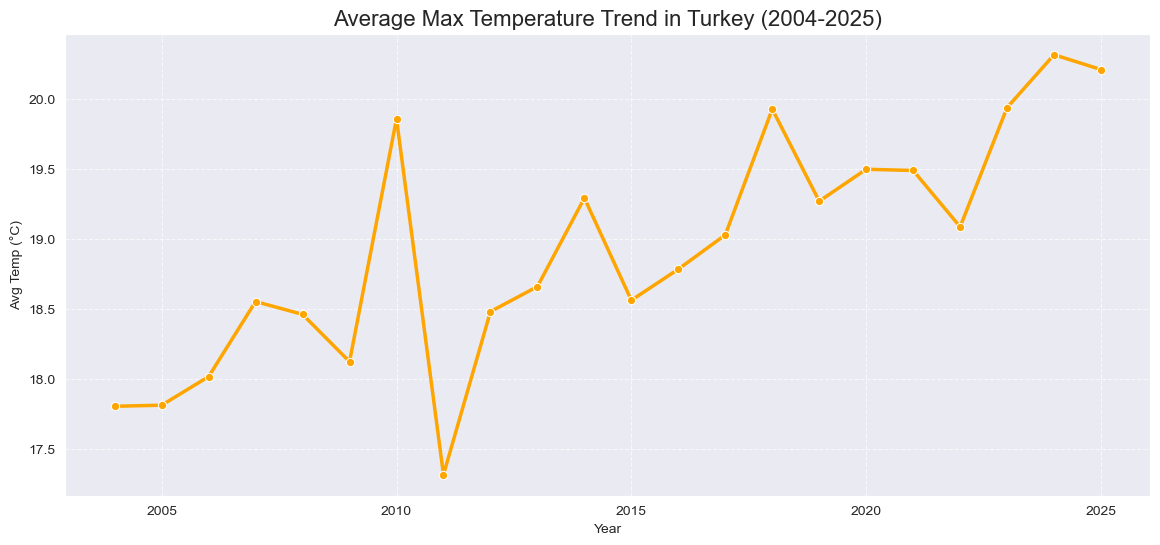

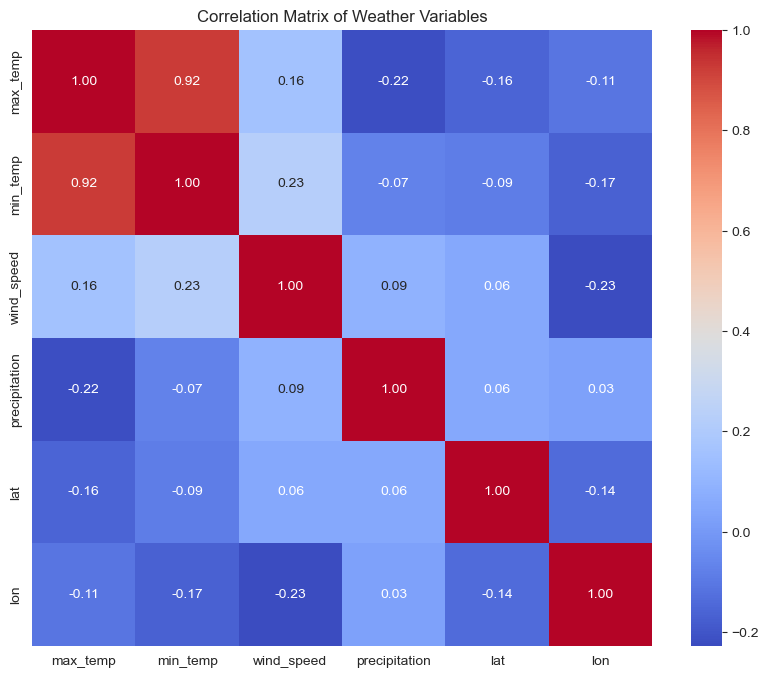

In [7]:
# 1. Average Max Temperature Trend Over Years in Turkey
df['year'] = df['date'].dt.year


df = df[df['year'] > 2003]

yearly_avg = df.groupby('year')['max_temp'].mean()

plt.figure(figsize=(14, 6))
sns.lineplot(x=yearly_avg.index, y=yearly_avg.values, marker='o', color='orange', linewidth=2.5)
plt.title("Average Max Temperature Trend in Turkey (2004-2025)", fontsize=16)
plt.ylabel("Avg Temp (°C)")
plt.xlabel("Year")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# 2. Correlation Matrix (Heatmap)
plt.figure(figsize=(10, 8))
numeric_cols = ['max_temp', 'min_temp', 'wind_speed', 'precipitation', 'lat', 'lon']
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Weather Variables")
plt.show()

Cell 4: Feature Engineering

In [5]:
print("Generating new features...")

# Extract Time Features
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['day_of_year'] = df['date'].dt.dayofyear

# Physics Feature: Diurnal Temperature Range (Max - Min)
# Clouds usually trap heat at night (low range), while clear skies allow cooling (high range).
df['temp_range'] = df['max_temp'] - df['min_temp']

# Target Simplification for Classification
# Grouping WMO codes into 4 main categories
def simplify_weather(code):
    code = int(code)
    if code in [0, 1, 2]: return "Sunny"
    elif code in [3, 45, 48]: return "Cloudy"
    elif code in [71, 73, 75, 77, 85, 86, 66, 67]: return "Snow"
    else: return "Rain"

df['weather_simple'] = df['weather_code'].apply(simplify_weather)

print("New Features Added: 'temp_range', 'weather_simple' ")
df[['date', 'max_temp', 'min_temp', 'temp_range', 'weather_simple']].head()

Generating new features...
New Features Added: 'temp_range', 'weather_simple' 


,date,max_temp,min_temp,temp_range,weather_simple
366,2004-01-01 21:00:00+00:00,9.2845,6.9845,2.300000,Rain
367,2004-01-02 21:00:00+00:00,11.1345,7.2845,3.850001,Rain
368,2004-01-03 21:00:00+00:00,12.3345,8.3845,3.950000,Rain
369,2004-01-04 21:00:00+00:00,12.8845,7.9845,4.900000,Rain
370,2004-01-05 21:00:00+00:00,12.3345,7.1845,5.150000,Rain


Cell 5: Model 1 - Temperature Prediction (Regression)

Training Random Forest Regressor...

Temperature Model MAE: 3.57 °C


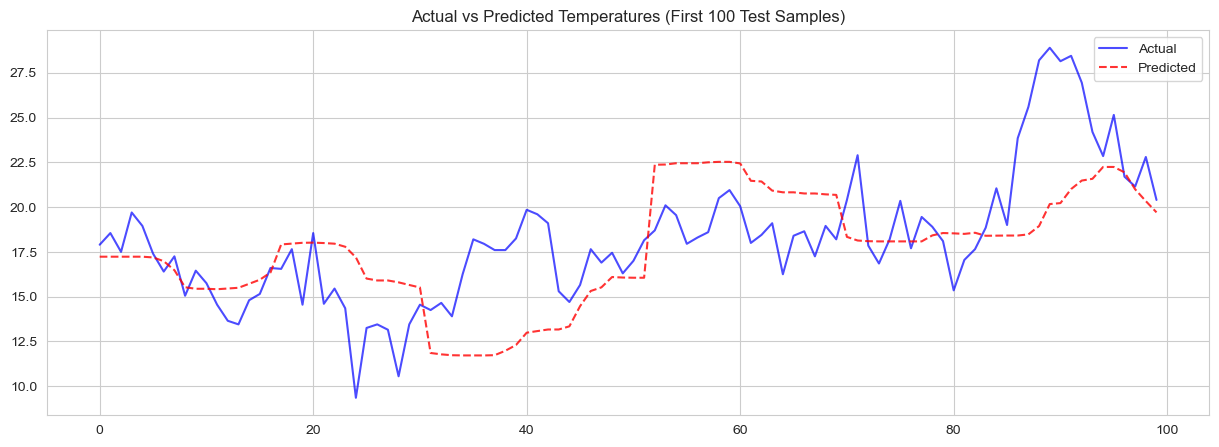

In [11]:
# --- STEP 1: RANDOM FOREST REGRESSOR ---

# Features & Target
features_reg = ['lat', 'lon', 'year', 'month', 'day', 'day_of_year']
target_reg = 'max_temp'

X = df[features_reg]
y = df[target_reg]

# Time-Based Split (Train on past, Test on future)
cutoff_year = 2024
X_train = X[df['year'] < cutoff_year]
y_train = y[df['year'] < cutoff_year]
X_test = X[df['year'] >= cutoff_year]
y_test = y[df['year'] >= cutoff_year]

# Train Model
print("Training Random Forest Regressor...")
# Optimized parameters to prevent overfitting and keep file size small
rf_temp = RandomForestRegressor(n_estimators=100, max_depth=12, min_samples_leaf=20, n_jobs=-1, random_state=42)
rf_temp.fit(X_train, y_train)

# Evaluate
y_pred_temp = rf_temp.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_temp)

print(f"\nTemperature Model MAE: {mae:.2f} °C")

# Visualization: Actual vs Predicted (Sample)
plt.figure(figsize=(15, 5))
plt.plot(y_test.values[:100], label='Actual', color='blue', alpha=0.7)
plt.plot(y_pred_temp[:100], label='Predicted', color='red', linestyle='--', alpha=0.8)
plt.title("Actual vs Predicted Temperatures (First 100 Test Samples)")
plt.legend()
plt.show()

Cell 6: Model 2 - Weather Condition (Classification)

Training Random Forest Classifier...

☁️ Weather Classification Accuracy: 60.83%

Classification Report:
              precision    recall  f1-score   support

      Cloudy       0.53      0.56      0.55     19433
        Rain       0.70      0.60      0.65     18587
        Snow       0.48      0.81      0.60      4106
       Sunny       0.67      0.62      0.65     17085

    accuracy                           0.61     59211
   macro avg       0.59      0.65      0.61     59211
weighted avg       0.62      0.61      0.61     59211



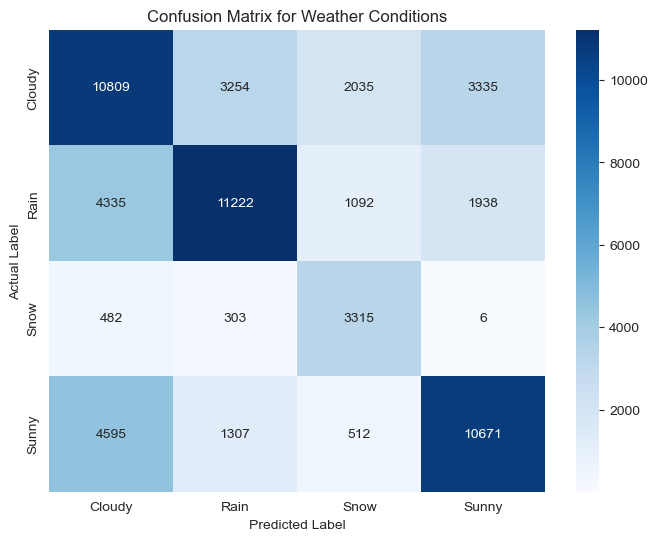

In [12]:
# --- STEP 2: RANDOM FOREST CLASSIFIER ---

# We include temperature data as features because they are physically linked to weather conditions.
features_cls = ['lat', 'lon', 'year', 'month', 'day_of_year', 'max_temp', 'min_temp', 'temp_range']
target_cls = 'weather_simple'

# Drop missing values if any
df_clean = df.dropna(subset=features_cls + [target_cls])

X = df_clean[features_cls]
y = df_clean[target_cls]

# Split Data
X_train = X[df_clean['year'] < cutoff_year]
y_train = y[df_clean['year'] < cutoff_year]
X_test = X[df_clean['year'] >= cutoff_year]
y_test = y[df_clean['year'] >= cutoff_year]

# Train Model
print("Training Random Forest Classifier...")
# 'balanced' weights help with rare classes like Snow
rf_class = RandomForestClassifier(n_estimators=100, max_depth=15, min_samples_leaf=10, class_weight='balanced', n_jobs=-1, random_state=42)
rf_class.fit(X_train, y_train)

# Evaluate
y_pred_class = rf_class.predict(X_test)
acc = accuracy_score(y_test, y_pred_class)

print(f"\n☁️ Weather Classification Accuracy: {acc:.2%}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_class))

# Visualization: Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_class, labels=rf_class.classes_)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf_class.classes_, yticklabels=rf_class.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix for Weather Conditions')
plt.show()